In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA
import uncertainty_toolbox as uct

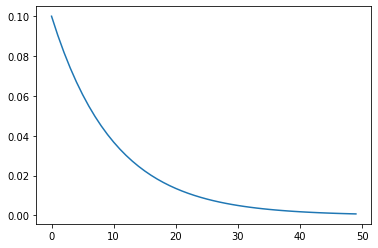

In [2]:
x = jnp.array([i for i in range(50)])
expx = 0.1 * jnp.exp(-x/10)
plt.plot(expx)

In [3]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')
print(blosum92)
print(len(AA_list))

[[ 4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1  0 -4]
 [-1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1  0 -1 -4]
 [-2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  3  0 -1 -4]
 [-2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4  1 -1 -4]
 [ 0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -3 -2 -4]
 [-1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0  3 -1 -4]
 [-1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4]
 [ 0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -2 -1 -4]
 [-2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0  0 -1 -4]
 [-1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3 -3 -1 -4]
 [-1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4 -3 -1 -4]
 [-1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0  1 -1 -4]
 [-1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3 -1 -1 -4]
 [-2 -3 -3 -3 -2 -3 -3 -3

In [4]:
avg92 = jnp.sum(blosum92)/24/24
sum92 = 0.
for row in blosum92:
    for aa in row:
        sum92 += (aa-avg92)**2
std92 = jnp.sqrt(sum92 / 24/24)
print(avg92)
print(std92)

-1.2604167
2.166242


In [5]:
def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += (blosum92[idx1][idx2] - avg92)/std92
        #jax.nn.sigmoid(score/len(seqlist1))
    return score/len(seqlist1)
    #return score/len(seqlist1)
    
def hamming(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    seq_len = len(seqlist1)
    for i in range(seq_len):
        if seqlist1[i] == seqlist2[i]:
            score += 1.
    return score / seq_len

In [6]:
target_seq = 'TARGETPEPTIDE'
#target_seq = 'THISISTARGETPEPTIDE'

oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)

seqs = ['ISQLRYICEVIWF']
#seqs = ['ISQLRYICEVIWFQGTHPI']

reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)

print(labels)

[0.01368617]


In [7]:
with open('../10kseqs.txt') as f:
    readfile = f.readlines()
    random_seqs = f'{readfile[0]}'.split(' ')[:-1]
score_distribution = []
#print(list(random_seqs[-2]))
for random_seq in random_seqs:
    score_distribution.append(blosum(target_seq, random_seq))

In [9]:
#print(np.histogram(score_distribution, bins=100))
print(np.std(score_distribution))
#plt.hist(score_distribution, bins='auto')
#plt.show()

(array([  1,   2,   0,   2,   0,   4,   0,   6,   0,  22,   0,  36,  73,
         0,  82,   0, 147,   0, 183,   0, 251,   0, 293,   0, 369, 381,
         0, 478,   0, 514,   0, 559,   0, 563,   0, 539,   0, 574, 589,
         0, 520,   0, 477,   0, 447,   0, 419,   0, 394, 346,   0, 271,
         0, 253,   0, 225,   0, 200,   0, 174,   0, 116,  92,   0,  78,
         0,  67,   0,  57,   0,  46,   0,  36,   0,  35,  26,   0,  13,
         0,   5,   0,  10,   0,   8,   0,   5,   0,   5,   4,   0,   1,
         0,   0,   0,   0,   0,   1,   0,   0,   1]), array([-0.66100234, -0.641827  , -0.62265164, -0.6034763 , -0.5843009 ,
       -0.5651255 , -0.5459502 , -0.5267748 , -0.5075995 , -0.48842412,
       -0.46924874, -0.4500734 , -0.43089804, -0.4117227 , -0.3925473 ,
       -0.37337196, -0.3541966 , -0.33502126, -0.31584588, -0.29667053,
       -0.27749518, -0.25831982, -0.23914446, -0.2199691 , -0.20079374,
       -0.18161838, -0.16244301, -0.14326766, -0.1240923 , -0.10491695,
       -0

In [7]:
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
forward_t, full_forward_t, seq_t = alpdesign.build_e2e(c)
def gen(k, n): return jax.random.normal(key, shape=(n, 13, 20))
'''
key1, key2 = jax.random.split(key)
start_params = seq_t.init(key1, jnp.tile(
    jnp.squeeze(gen(key2, 1)), (c.model_number, 1)))
best_v, params, train_loss, bo_loss = alpdesign.alg_iter(
    key2, reps, labels, full_forward_t, seq_t, c, x0_gen=gen,
    start_params=start_params
)
'''


'\nkey1, key2 = jax.random.split(key)\nstart_params = seq_t.init(key1, jnp.tile(\n    jnp.squeeze(gen(key2, 1)), (c.model_number, 1)))\nbest_v, params, train_loss, bo_loss = alpdesign.alg_iter(\n    key2, reps, labels, full_forward_t, seq_t, c, x0_gen=gen,\n    start_params=start_params\n)\n'

In [8]:
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
def loop(key, reps, labels, params, idx):
    bo_xi = 0.5 * jnp.exp(-idx/10)
    #forward_t, full_forward_t, seq_t = alpdesign.build_e2e(c)
    key, key2 = jax.random.split(key)
    start_params = seq_t.init(key, jnp.tile(
    jnp.squeeze(gen(key2, 1)), (c.model_number, 1)))
    best_v, params, train_loss, bo_loss = alpdesign.alg_iter(
        key2, reps, labels, full_forward_t, seq_t, c, x0_gen=gen,
        start_params=start_params, bo_xi=bo_xi
        )
    s = decode_seq(best_v)
    reps = np.concatenate((reps, get_reps([s])[0]))
    yhat = forward_t.apply(params, key, get_reps([s])[0])
    y = blosum(target_seq, s)
    print(s, y, yhat[0], yhat[1])
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    return key, reps, labels, s, params, bo_loss, train_loss

    

In [ ]:
y = []
yhat0 = []
yhat1 = []
for i in range(50):
    print(i)
    params = None
    key, _ = jax.random.split(key, num=2)
    key, reps, labels, final_vec, params, bo_loss, mlp_loss= loop(key, reps, labels, params, i)
    yhat = forward_t.apply(params, key, get_reps([s])[0])
    yhat0.append(yhat[0])
    yhat1.append(yhat[1])
    y.append(blosum(target_seq, final_vec))

0
['Q', 'K', 'K', 'P', 'I', 'V', 'I', 'V', 'P', 'G', 'G', 'K', 'G'] 0.15572585 -0.07009122 6.135544
1
['C', 'N', 'D', 'D', 'D', 'C', 'D', 'C', 'S', 'D', 'D', 'K', 'K'] 0.04919606 0.051825892 0.16729635
2
['L', 'F', 'V', 'V', 'T', 'M', 'V', 'M', 'L', 'F', 'M', 'M', 'M'] -0.2703932 0.030125514 0.4679694
3
['Y', 'F', 'H', 'E', 'M', 'G', 'K', 'Y', 'K', 'K', 'G', 'E', 'R'] -0.021823779 0.021097189 0.247864
4
['C', 'G', 'G', 'H', 'D', 'P', 'S', 'G', 'N', 'C', 'D', 'G', 'G'] 0.013686147 -0.16456774 7.5496655
5
['E', 'P', 'C', 'H', 'C', 'R', 'D', 'H', 'D', 'D', 'D', 'H', 'H'] -0.09284361 -0.086299114 0.54100865
6
['M', 'I', 'K', 'K', 'I', 'Q', 'I', 'K', 'Y', 'I', 'V', 'V', 'K'] 0.19123577 0.061350215 0.35240775
7
['T', 'K', 'I', 'K', 'V', 'I', 'G', 'I', 'D', 'K', 'K', 'K', 'N'] 0.049196076 -0.019709343 3.4178395
8
['M', 'K', 'N', 'T', 'K', 'P', 'K', 'P', 'P', 'K', 'K', 'D', 'D'] 0.7593945 0.0667077 0.7861258
9
['Q', 'R', 'P', 'K', 'K', 'P', 'K', 'P', 'P', 'P', 'P', 'P', 'K'] 0.40429527 0.23133

In [11]:
a = np.array([i for i in range(10)])
b = np.argsort(a)
print(b[:3])
a[b[:3]]
np.int(np.ceil(0.3))

[0 1 2]


1

In [17]:
# Load an example dataset of 100 predictions, uncertainties, and ground truth values
#predictions, predictions_std, y, x = uct.data.synthetic_sine_heteroscedastic(100)

# Compute all uncertainty metrics
metrics = uct.metrics.get_all_metrics(np.array(yhat0), np.array(yhat1), np.array(y))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.37it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:00<00:00, 12.63it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.424
  RMSE          0.520
  MDAE          0.360
  MARPD         113.642
  R2            -1.115
  Correlation   0.030
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.154
  Mean-absolute Calibration Error       0.127
  Miscalibration Area                   0.128
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.320
     Group Size: 0.56 -- Calibration Error: 0.178
     Group Size: 1.00 -- Calibration Error: 0.127
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.368
     Group Size: 0.56 -- Calibration Error: 0.222
     Group Size: 1.00 -- Calibration Error: 0.154
=============

Text(0.5, 1.0, 'Blosum Score vs N')

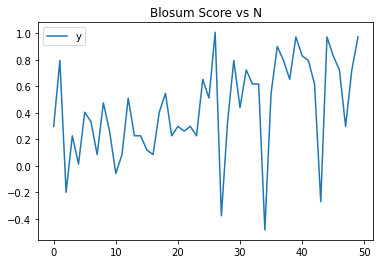

In [18]:
plt.figure()
plt.plot(y,label='y')
#plt.plot(yhat, label='yhat')
plt.legend()
plt.title('Blosum Score vs N')

In [ ]:
import pickle

with open('y.pkl', 'wb') as f1:
    pickle.dump(y, f1)
    
with open('yhat.pkl', 'wb') as f2:
    pickle.dump(yhat, f2)

In [ ]:
['T', 'P', 'D', 'P', 'S', 'P', 'P', 'D', 'P', 'P', 'T', 'D', 'P'] 1.2210236 0.48240328 0.11414045